# India ML Hiring Hackathon, Analytics Vidhya.

Problem Statement
Loan Delinquency Prediction
Loan default prediction is one of the most critical and crucial problem faced by financial institutions and organizations as it has a noteworthy effect on the profitability of these institutions. In recent years, there is a tremendous increase in the volume of non – performing loans which results in a jeopardizing effect on the growth of these institutions.
 

Therefore, to maintain a healthy portfolio, the banks put stringent monitoring and evaluation measures in place to ensure timely repayment of loans by borrowers. Despite these measures, a major proportion of loans become delinquent. Delinquency occurs when a borrower misses a payment against his/her loan.

 

Given the information like mortgage details, borrowers related details and payment details, our objective is to identify the delinquency status of loans for the next month given the delinquency status for the previous 12 months (in number of months).

In [1]:
## India ML Hiring Hackathon!
# pyforest-lazy is an opensource library that imports all popular #Python Data Science libraries
from pyforest import *
import pandas_profiling

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.simplefilter('ignore')

train_ = pd.read_csv('/home/aakash/Downloads/India_AV/train.csv')
test_ = pd.read_csv('/home/aakash/Downloads/India_AV/test.csv')
print(train_.shape) ## 29 data columns. 116058 data points.
print(test_.shape) # 35866 data points,
train_.head()

(116058, 29)
(35866, 28)


,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,...,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,05/2012,95,1.0,...,0,0,0,1,0,0,0,0,0,1
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,03/2012,72,1.0,...,0,0,0,0,0,0,0,1,0,1
2,742515242108,Z,Thornton-Davis,3.250,366000,180,2012-01-01,03/2012,49,1.0,...,0,0,0,0,0,0,0,0,0,1
3,601385667462,X,OTHER,4.750,135000,360,2012-02-01,04/2012,46,2.0,...,0,0,0,0,0,1,1,1,1,1
4,273870029961,X,OTHER,4.750,124000,360,2012-02-01,04/2012,80,1.0,...,3,4,5,6,7,8,9,10,11,1


In [ ]:
train_.profile_report()

In [ ]:
test_.profile_report()

In [2]:
## Concatenating the datasets so that we can do simultaneous preprocessing.
data = pd.concat([train_, test_],  axis = 0, ignore_index = False)

In [3]:
## Numerical and Categorical Columns,
num_col = [x for x in data.dtypes.index if data.dtypes[x] == 'float']
cat_col = [x for x in data.dtypes.index if data.dtypes[x] == 'object']
int_col = [x for x in data.dtypes.index if data.dtypes[x] == 'int64']

In [4]:
data.dtypes

borrower_credit_score       float64
co-borrower_credit_score    float64
debt_to_income_ratio        float64
financial_institution        object
first_payment_date           object
insurance_percent           float64
insurance_type              float64
interest_rate               float64
loan_id                       int64
loan_purpose                 object
loan_term                     int64
loan_to_value                 int64
m1                            int64
m10                           int64
m11                           int64
m12                           int64
m13                         float64
m2                            int64
m3                            int64
m4                            int64
m5                            int64
m6                            int64
m7                            int64
m8                            int64
m9                            int64
number_of_borrowers         float64
origination_date             object
source                      

# Insights

So this is a binary classification problem.
m13 -> our target variable.. to predict loan deliquency in the 13th month,

No missing values, in both train and test datasets.
Important Insights-
1). all mi's should be of type boolean and should only have 2 possible values, 0 and 1, so our first task will be to convert all other values(2,3,4..) to 1.

2). number_of_borrowers is highly correlated with co-borrower_credit_score (ρ = 0.9964984777) so we may drop one of them.

3). First Payment Date is a categorical variable. and 02/2012 is the same as Feb-12 and similarly for Mar, Apr, MAy,. 
Note- 
F1 score is our evaluation metric.

In [5]:
## first Payment Date,
data['first_payment_date'][data.first_payment_date == '02/2012'] = 0 
data['first_payment_date'][data.first_payment_date == 'Feb-12'] = 0 
data['first_payment_date'][data.first_payment_date == '03/2012'] = 1
data['first_payment_date'][data.first_payment_date == 'Mar-12'] = 1
data['first_payment_date'][data.first_payment_date == '04/2012'] = 2 
data['first_payment_date'][data.first_payment_date == 'Apr-12'] = 2
data['first_payment_date'][data.first_payment_date == '05/2012'] = 3 
data['first_payment_date'][data.first_payment_date == 'May-12'] = 3
data['first_payment_date'].value_counts()

2    69391
1    62341
3    19524
0      668
Name: first_payment_date, dtype: int64

In [6]:
## Origination Date
data['origination_date'][data.origination_date == '2012-01-01'] = 0 
data['origination_date'][data.origination_date == '01/01/12'] = 0
data['origination_date'][data.origination_date == '2012-02-01'] = 1
data['origination_date'][data.origination_date == '01/02/12'] = 1
data['origination_date'][data.origination_date == '2012-03-01'] = 2 
data['origination_date'][data.origination_date == '01/03/12'] = 2
data['origination_date'].value_counts()

1    68757
0    64144
2    19023
Name: origination_date, dtype: int64

In [7]:
## Categories to Codes,
data['finst'] = data.financial_institution.astype('category').cat.codes   
data['loan_purpose'] = data.loan_purpose.astype('category').cat.codes   
data['source'] = data.source.astype('category').cat.codes   
data['origination_date'] = data.origination_date.astype('category').cat.codes
data['first_payment_date'] = data.first_payment_date.astype('category').cat.codes

In [8]:
data.unpaid_principal_bal = np.abs(data.unpaid_principal_bal - data.unpaid_principal_bal.mean()) / data.unpaid_principal_bal.std() 
data.debt_to_income_ratio = np.abs(data.debt_to_income_ratio - data.debt_to_income_ratio.mean()) / data.debt_to_income_ratio.std() 

In [9]:
## mi's
int_col.remove('loan_id')
int_col.remove('loan_term')
int_col.remove('loan_to_value')
int_col.remove('unpaid_principal_bal')

for col in int_col:
    data[col][data[col] != 0] = 1

In [10]:
train = data[:train_.shape[0]]
test = data[train_.shape[0]:]

y = train['m13'].astype(int)
key1 = test.loan_id
train = train.drop('loan_id' , axis = 1)
test = test.drop('loan_id' , axis = 1)
train = train.drop('m13' , axis = 1)
test = test.drop('m13' , axis = 1)
train = train.drop('financial_institution' , axis = 1)
test = test.drop('financial_institution' , axis = 1)

data = pd.concat([train, test],  axis = 0, ignore_index = False)
print(train.shape); print(test.shape)

(116058, 27)
(35866, 27)


# Subsample

In [12]:
y.value_counts()

0    115422
1       636
Name: m13, dtype: int64

What is a sub-Sample?
In this scenario, our subsample will be a dataframe with a 50/50 ratio of fraud and non-fraud transactions. Meaning our sub-sample will have the same amount of fraud and non fraud transactions.

Why do we create a sub-Sample?

->Overfitting: Our classification models will assume that in most cases there are no frauds! What we want for our model is to be certain when a fraud occurs.

->Wrong Correlations.

# Resampling

A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling).

In [13]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

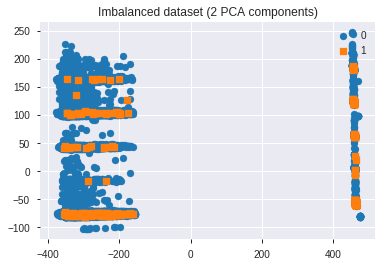

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(train)

plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')


# Random under-sampling and over-sampling with imbalanced-learn

In [19]:
## Over-sampling followed by under-sampling
from imblearn.over_sampling import SMOTE

smt = SMOTE(random_state=55)
X_smt, y_smt = smt.fit_sample(train, y)

# Let's then put 85% of our dataset into a training set and 15% of it into a test set. 
# We can use random_state because it is not a time series dataset that we are using.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_smt, y_smt, test_size=0.15, random_state=20, stratify=y_smt)

# LightGBM classifier

In [21]:
# Modelling
## Adding an Light GBM model
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
%matplotlib inline

import lightgbm as lgb

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return('f1', f1_score(y_true, y_hat), True)

In [22]:
def run_lgb(X_train, X_test, y_train, y_test, test_df):
    params = {
       "objective" : "binary",
       "n_estimators":10000,
       "reg_alpha" : 2.0,
       "reg_lambda":2.1,
       "n_jobs":-1,
       "colsample_bytree":.8,
       "min_child_weight":0.8,
       "subsample":0.8715623,
       "min_data_in_leaf":20,
       "nthread":4,
       "metric" : "f1",
       "num_leaves" : 100,
       "learning_rate" : 0.01,
       "verbosity" : -1,
       "seed": 120,
       "max_bin":60,
       'max_depth':15,
       'min_gain_to_split':.0222415,
       'scale_pos_weight':1
    }
    
    lgtrain = lgb.Dataset(X_train, label=y_train)
    lgval = lgb.Dataset(X_test, label=y_test)
    evals_result = {}
    model = lgb.train(params, lgtrain, 10000, 
                      valid_sets=[lgtrain, lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=100, 
                      evals_result=evals_result,
                      feval=lgb_f1_score)
    
    pred_test_y = model.predict(test_df, num_iteration=model.best_iteration)
    return(pred_test_y, model, evals_result)

In [23]:
pred_test, model, evals_result = run_lgb(X_train, X_test, y_train, y_test, test)
print("LightGBM Training Completed...")

Training until validation scores don't improve for 100 rounds.
[100]	training's f1: 0.991764	valid_1's f1: 0.991077
[200]	training's f1: 0.994656	valid_1's f1: 0.994321
[300]	training's f1: 0.996677	valid_1's f1: 0.996096
[400]	training's f1: 0.997311	valid_1's f1: 0.996647
[500]	training's f1: 0.997842	valid_1's f1: 0.99737
[600]	training's f1: 0.998107	valid_1's f1: 0.997717
[700]	training's f1: 0.998286	valid_1's f1: 0.997977
[800]	training's f1: 0.998347	valid_1's f1: 0.998035
[900]	training's f1: 0.998408	valid_1's f1: 0.997977
Early stopping, best iteration is:
[804]	training's f1: 0.998357	valid_1's f1: 0.998064
LightGBM Training Completed...


<Figure size 1440x1080 with 0 Axes>

Text(0.5, 1.0, 'LightGBM Features (avg over folds)')

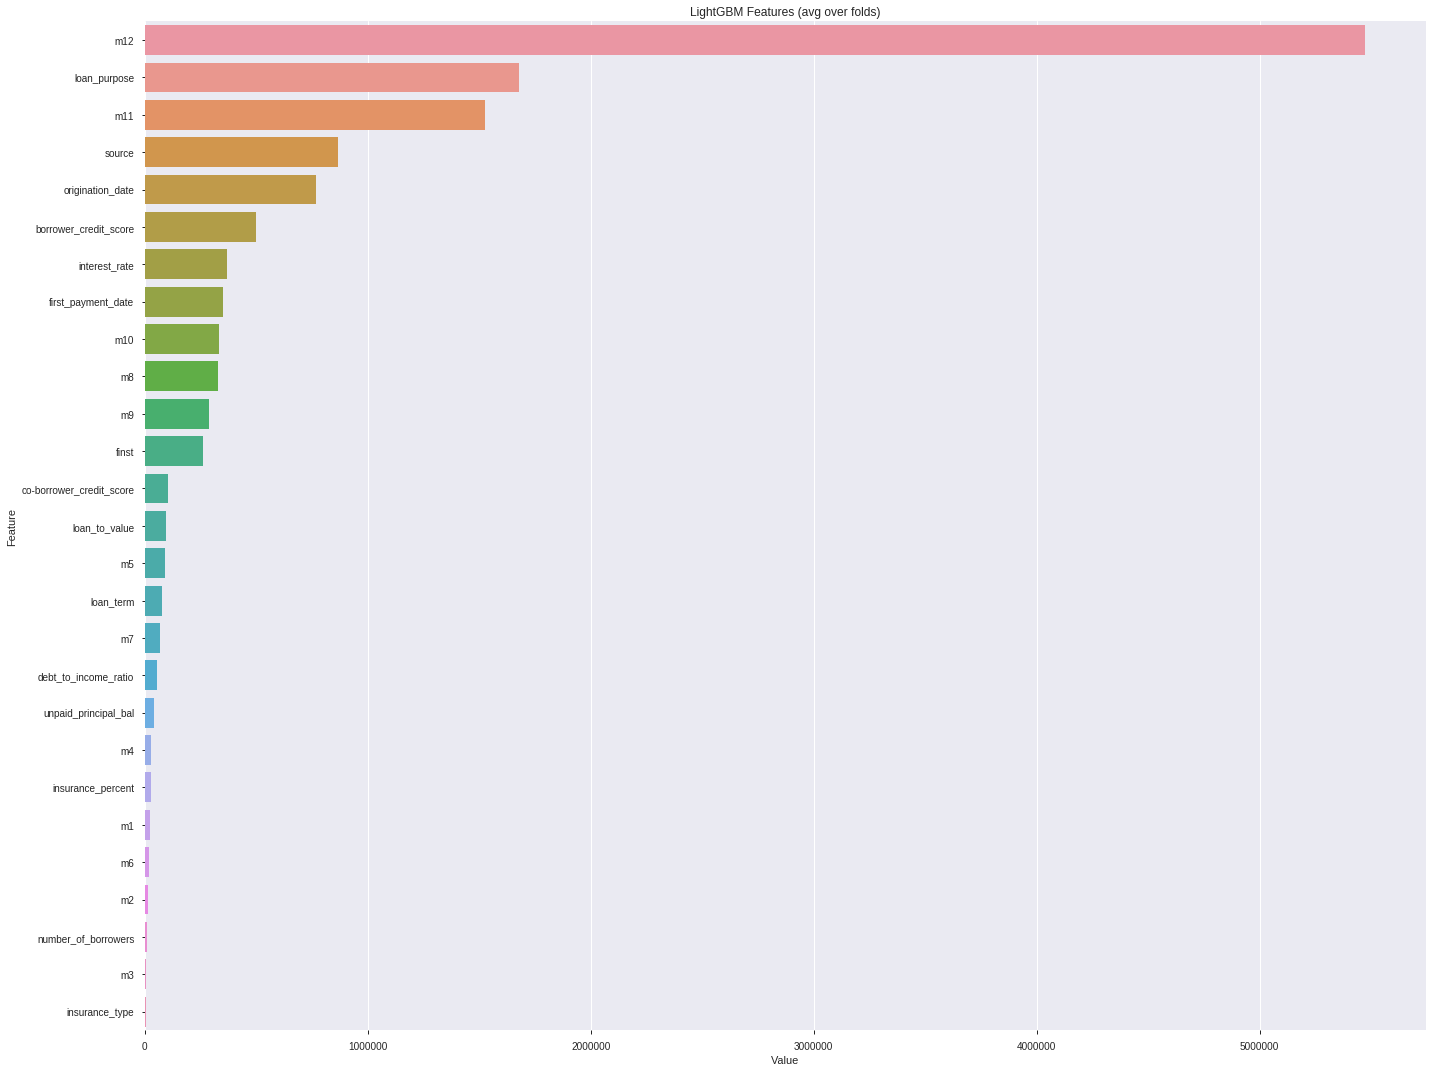

In [25]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(importance_type='gain'),train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(50))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [39]:
sub = pd.read_csv("/home/aakash/Downloads/India_AV/sample_submission.csv")
sub['m13'] = pred_test
sub['m13'] = sub['m13'].apply(lambda x : 1 if (x>=0.40) else 0)
sub['m13'].sum()
sub.to_csv('Final_.csv',index=False)

128